In [2]:
import os
from shutil import copy

#import tensorflow as tf
#import tensorflow.keras
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Conv2D, Input, BatchNormalization, ReLU
from keras.regularizers import l1
from keras.optimizers import RMSprop, Adagrad, Adam, SGD
from keras.applications import VGG16
from keras.applications.mobilenetv2 import MobileNetV2
from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix

import PIL.Image

from pprint import pprint

C:\Users\Sophie\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Getting Started

In [2]:
def applyBoundingBox(image, boundingbox):
    x = int(float(boundingbox[0]))
    y = int(float(boundingbox[1]))
    width = int(float(boundingbox[2]))
    height = int(float(boundingbox[3]))
    #print([x, y, width, height])
        
    imagecropped = image[y:y+height,x:x+width]
    
#     print("len(image): ", len(image))
#     print("len(image)[0]: ", len(image[0]))
#     print("len(image)[0][0]: ", len(image[0][0]))
    
#     print("len(imagecropped): ", len(imagecropped))
#     print("len(imagecropped)[0]: ", len(imagecropped[0]))
#     print("len(imagecropped)[0][0]: ", len(imagecropped[0][0]))
    return imagecropped

In [3]:
def copyImage(src, label, tr_te, dst="", image=None):
    
        cat = os.path.join(tr_te, label)
        new_dst = os.path.join(dst,cat)
        
        #print(src)
        #print(cat)
        #print(new_dst)
        
        # check if directory exists
        if os.path.isdir(new_dst):
            pass
        else:        
            # make diretory
            os.mkdir(new_dst)

        #print(new_dst)
        if image is not None:
            file = src.split("/")[-1]
            new_dst = os.path.join(new_dst,file)
            result = PIL.Image.fromarray(image)
            result.save(new_dst)
        else:
            copy(src, new_dst)

In [5]:
def processAttributes(attrs, num_attr=1):     
    # has wing colour red attribute #23->22
    # select feature 2 (visible)
    return int(attrs[22][2])

In [6]:
#generateData("./CUB_200_2011/CUB_200_2011/CUB_200_2011/train.txt", "./Outex_TC_00030.tar/Outex-TC-00030/images/", "C:/Users/Sophie/Documents/GitHub/CSI5139/csi5139_a2/Outex-TC-00030/test/")

drt = "./CUB_200_2011/CUB_200_2011/CUB_200_2011/"
drt_images = "./CUB_200_2011/CUB_200_2011/CUB_200_2011/images"
dst = "./CUB_200_2011_generator/"
dst_bb = "./CUB_200_2011_generator_boundingbox/"

# images.txt
with open(os.path.join(drt, "images.txt"), "r", encoding='utf-8') as f:
    images_txt = f.read().splitlines()

# train_test_split.txt
with open(os.path.join(drt, "train_test_split.txt"), "r", encoding='utf-8') as f:
    tr_te_txt = f.read().splitlines()

# image_class_labels.txt
with open(os.path.join(drt, "image_class_labels.txt"), "r", encoding='utf-8') as f:
    class_labels_txt = f.read().splitlines()

# bounding_boxes.txt
with open(os.path.join(drt, "bounding_boxes.txt"), "r", encoding='utf-8') as f:
    bounding_boxes_txt = f.read().splitlines()
    
# image_attribute_labels.txt
with open(os.path.join(drt, "./attributes/image_attribute_labels.txt"), "r", encoding='utf-8') as f:
    image_attribute_labels_txt = f.read().splitlines()

image_attribute_labels = []
for entry in image_attribute_labels_txt:
    image_attribute_labels.append(entry.split(' '))
    
print(images_txt[:2])
print(tr_te_txt[:2])
print(class_labels_txt[:2])
print(bounding_boxes_txt[:2])
print(image_attribute_labels[:2])
print("# images_txt: ", len(images_txt))
print("# tr_te_txt: ", len(tr_te_txt))
print("# class_labels_txt: ", len(class_labels_txt))
print("# bounding_boxes_txt: ", len(bounding_boxes_txt))
print("# image_attribute_labels: ", len(image_attribute_labels))

#process attributes into groups of 312
n = 312
chunk = []
for i in range(0, len(image_attribute_labels), n):
    chunk.append(image_attribute_labels[i:i+n])

print("# chunk: ", len(chunk))
print("# chunk[0]: ", len(chunk[0]))
# print(chunk[0])
# print(chunk[1])

#birdspecies_subset = {"cardinal": 17, "american_goldﬁnch": 47, "evening_grosbeak": 55, "song_sparrow": 129, "tree_sparrow": 130, "house_sparrow": 118, "fox_sparrow":120, "canada_warbler":162, "myrtle warbler": 171, "house_wren": 196 , "red-winged_blackbird": 10, "boat_tailed_grackle":49}
birdspecies_subset = {"17": "cardinal", "47": "american_goldﬁnch", "55": "evening_grosbeak", "129": "song_sparrow", "130": "tree_sparrow", "118": "house_sparrow", "120": "fox_sparrow", "162": "canada_warbler", "171": "myrtle warbler", "196": "house_wren", "10": "red-winged_blackbird", "49": "boat_tailed_grackle"}
label_subset = set(birdspecies_subset.keys())
print("label_subset: ", label_subset)

boundingbox = True
bb_input_train = []
bb_input_test = []

attr_train = []
attr_test = []
for i, label in enumerate(class_labels_txt):
    label = label.split(' ')[-1]
    if label in label_subset:
        file = images_txt[i].split(' ')[-1]
        tr_te = tr_te_txt[i].split(' ')[-1]
        b_b = bounding_boxes_txt[i].split(' ')[1:]
        b_b = [float(b) for b in b_b]
        attr = chunk[i]
        
        if tr_te == "1":
            tr_te = "train"
            bb_input_train.append(b_b)
            attr_train.append(processAttributes(attr))
        elif tr_te == "0":
            tr_te = "test"
            bb_input_test.append(b_b)
            attr_test.append(processAttributes(attr))
        else:
            break
        
#         print(file)
#         src = os.path.join(drt_images, file)
        
#         if boundingbox:
#             image = PIL.Image.open(src)
#             image = np.array(image)
#             image = applyBoundingBox(image, b_b)
#             copyImage(file, label, tr_te, dst_bb, image)
#         else:
#             src = os.path.join(drt_images, file)
#             copyImage(src, label, tr_te, dst) 

bb_input_train = np.array(bb_input_train)
bb_input_test = np.array(bb_input_test)
attr_train = np.array(attr_train)
attr_test = np.array(attr_test)

['1 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg', '2 001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg']
['1 0', '2 1']
['1 1', '2 1']
['1 60.0 27.0 325.0 304.0', '2 139.0 30.0 153.0 264.0']
[['1', '1', '0', '3', '27.7080'], ['1', '2', '0', '3', '27.7080']]
# images_txt:  11788
# tr_te_txt:  11788
# class_labels_txt:  11788
# bounding_boxes_txt:  11788
# image_attribute_labels:  3677856
# chunk:  11788
# chunk[0]:  312
label_subset:  {'118', '162', '171', '10', '120', '129', '49', '17', '196', '47', '55', '130'}


In [7]:
print("# bb_input_train: ", len(bb_input_train))
print(bb_input_train[:2])

print("# bb_input_test: ", len(bb_input_test))
print(bb_input_test[:2])

print("# attr_train: ", len(attr_train))
print(attr_train)

print("# attr_test: ", len(attr_test))
print(attr_test)

# bb_input_train:  359
[[187. 129. 131. 226.]
 [130. 124. 351. 205.]]
# bb_input_test:  357
[[110. 144. 171. 156.]
 [218.  39. 205. 360.]]
# attr_train:  359
[1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1
 1 1 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
# attr_test:  357
[0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 0 1

In [8]:
datagen = ImageDataGenerator(rescale=.1/255)

train_batchsize = 359 # 160 images per 68 classes
test_batchsize = 357 # 20 images per 68 classes

train_generator_temp = datagen.flow_from_directory(
    directory=r"./CUB_200_2011_generator/train/",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=train_batchsize,
    class_mode="categorical",
    shuffle=False
)

test_generator_temp = datagen.flow_from_directory(
    directory=r"./CUB_200_2011_generator/test/",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=test_batchsize,
    class_mode="categorical",
    shuffle=False
)

print("Train generator length: ", len(train_generator_temp))
print("Test generator length: ", len(test_generator_temp))
print("Target size: ", train_generator_temp.target_size)

Found 359 images belonging to 12 classes.
Found 357 images belonging to 12 classes.
Train generator length:  1
Test generator length:  1
Target size:  (96, 96)


In [9]:
Xtrain, ytrain = train_generator_temp.next()
Xtest, ytest = test_generator_temp.next()
print("Xtrain: ", Xtrain.shape)
print("ytrain: ", ytrain.shape)
print("Xtest: ", Xtest.shape)
print("ytest: ", ytest.shape)

#print(X[100])
print(ytrain)

print("Generator indices: ", test_generator_temp.class_indices)
print("Generator filenames:", test_generator_temp.filenames[:10])

Xtrain:  (359, 96, 96, 3)
ytrain:  (359, 12)
Xtest:  (357, 96, 96, 3)
ytest:  (357, 12)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Generator indices:  {'10': 0, '118': 1, '120': 2, '129': 3, '130': 4, '162': 5, '17': 6, '171': 7, '196': 8, '47': 9, '49': 10, '55': 11}
Generator filenames: ['10\\Red_Winged_Blackbird_0006_6005.jpg', '10\\Red_Winged_Blackbird_0007_3706.jpg', '10\\Red_Winged_Blackbird_0009_5841.jpg', '10\\Red_Winged_Blackbird_0010_6386.jpg', '10\\Red_Winged_Blackbird_0011_5845.jpg', '10\\Red_Winged_Blackbird_0013_5762.jpg', '10\\Red_Winged_Blackbird_0017_4116.jpg', '10\\Red_Winged_Blackbird_0022_4483.jpg', '10\\Red_Winged_Blackbird_0024_4180.jpg', '10\\Red_Winged_Blackbird_0027_4123.jpg']


# Model

# Regularization

Evaluate model for classiﬁcation with three diﬀerent regularizations: dropout, batch normalization and l1-regularization.

#### Dropout

In [75]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
#mobilenetv2_model.summary()

# last layers output
x = mobilenetv2_model.layers[33].output
# Flatten as before
x = ReLU()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(12, activation='softmax')(x)

# Transfer models
mv2_transfer_dropout = Model(inputs=mobilenetv2_model.input, outputs=x)

# SGD optimizer
sgd = SGD()
mv2_transfer_dropout.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
epochs = 12
batch_size = 32

for layer in mv2_transfer_dropout.layers:
    print(layer, layer.trainable)
    
mv2_transfer_dropout.summary()

hist_mv2_dropout = mv2_transfer_dropout.fit(Xtrain, ytrain, 
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(Xtest, ytest),
        verbose=1,
        shuffle=True)

score = mv2_transfer_dropout.evaluate(Xtrain, ytrain)
print(score)

score = mv2_transfer_dropout.evaluate(Xtest, ytest)
print(score)

<keras.engine.input_layer.InputLayer object at 0x000001C888CFDCC0> False
<keras.layers.convolutional.Conv2D object at 0x000001C889355DA0> True
<keras.layers.normalization.BatchNormalization object at 0x000001C888CFD9B0> True
<keras.layers.advanced_activations.ReLU object at 0x000001C888CFD400> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001C888CFD860> True
<keras.layers.normalization.BatchNormalization object at 0x000001C888CFD128> True
<keras.layers.advanced_activations.ReLU object at 0x000001C888CE0940> True
<keras.layers.convolutional.Conv2D object at 0x000001C888CAC470> True
<keras.layers.normalization.BatchNormalization object at 0x000001C888C6E080> True
<keras.layers.convolutional.Conv2D object at 0x000001C888C82FD0> True
<keras.layers.normalization.BatchNormalization object at 0x000001C888C44550> True
<keras.layers.advanced_activations.ReLU object at 0x000001C888C11048> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001C888C310F0> True
<keras

Train on 359 samples, validate on 357 samples
Epoch 1/12
359/359 [==============================] - 180s 500ms/step - loss: 11.4461 - acc: 0.1031 - val_loss: 12.8075 - val_acc: 0.0840
Epoch 2/12
359/359 [==============================] - 141s 394ms/step - loss: 9.3853 - acc: 0.1309 - val_loss: 7.7862 - val_acc: 0.0840
Epoch 3/12
359/359 [==============================] - 144s 401ms/step - loss: 2.7717 - acc: 0.2507 - val_loss: 3.3013 - val_acc: 0.1261
Epoch 4/12
359/359 [==============================] - 143s 398ms/step - loss: 1.9454 - acc: 0.3872 - val_loss: 2.9579 - val_acc: 0.1261
Epoch 5/12
359/359 [==============================] - 140s 389ms/step - loss: 1.6614 - acc: 0.4457 - val_loss: 2.9851 - val_acc: 0.1373
Epoch 6/12
359/359 [==============================] - 141s 393ms/step - loss: 1.3369 - acc: 0.5599 - val_loss: 2.8456 - val_acc: 0.1541
Epoch 7/12
359/359 [==============================] - 145s 403ms/step - loss: 1.1783 - acc: 0.5877 - val_loss: 2.7210 - val_acc: 0.1709


In [77]:
mv2_transfer_dropout.save('./models/mv2_transfer_dropout5.h5')

In [78]:
hist_mv2_dropout = hist_mv2_dropout.history

In [79]:
# save history
with open('./runs/hist_mv2_dropout5.hist', 'w', encoding="utf-8") as fout:
    pprint(hist_mv2_dropout, fout)

#### Batch Normalization

In [70]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
#mobilenetv2_model.summary()

# last layers output
x = mobilenetv2_model.layers[33].output
# Flatten as before
x = ReLU()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(12, activation='softmax')(x)

# Transfer models
mv2_transfer_batchnorm = Model(inputs=mobilenetv2_model.input, outputs=x)

# SGD optimizer
sgd = SGD()
mv2_transfer_batchnorm.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
epochs = 12
batch_size = 32

for layer in mv2_transfer_batchnorm.layers:
    print(layer, layer.trainable)
    
mv2_transfer_batchnorm.summary()

hist_mv2_batchnorm = mv2_transfer_batchnorm.fit(Xtrain, ytrain, 
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(Xtest, ytest),
        verbose=1,
        shuffle=True)

score = mv2_transfer_batchnorm.evaluate(Xtrain, ytrain)
print(score)

score = mv2_transfer_batchnorm.evaluate(Xtest, ytest)
print(score)

<keras.engine.input_layer.InputLayer object at 0x000001C87D9EBFD0> False
<keras.layers.convolutional.Conv2D object at 0x000001C87D9E1EF0> True
<keras.layers.normalization.BatchNormalization object at 0x000001C87D9E12E8> True
<keras.layers.advanced_activations.ReLU object at 0x000001C87C7BA2B0> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001C87D9F0518> True
<keras.layers.normalization.BatchNormalization object at 0x000001C87D9F0438> True
<keras.layers.advanced_activations.ReLU object at 0x000001C8705A9C18> True
<keras.layers.convolutional.Conv2D object at 0x000001C870613EF0> True
<keras.layers.normalization.BatchNormalization object at 0x000001C870696CF8> True
<keras.layers.convolutional.Conv2D object at 0x000001C8706865C0> True
<keras.layers.normalization.BatchNormalization object at 0x000001C87C150860> True
<keras.layers.advanced_activations.ReLU object at 0x000001C87C185F28> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001C87C22AC50> True
<keras

Train on 359 samples, validate on 357 samples
Epoch 1/12
359/359 [==============================] - 180s 502ms/step - loss: 3.0784 - acc: 0.1281 - val_loss: 3.6477 - val_acc: 0.1232
Epoch 2/12
359/359 [==============================] - 138s 384ms/step - loss: 1.4991 - acc: 0.5320 - val_loss: 3.0492 - val_acc: 0.1485
Epoch 3/12
359/359 [==============================] - 124s 344ms/step - loss: 0.8124 - acc: 0.8496 - val_loss: 3.6232 - val_acc: 0.1457
Epoch 4/12
359/359 [==============================] - 129s 360ms/step - loss: 0.4851 - acc: 0.9471 - val_loss: 2.6500 - val_acc: 0.1961
Epoch 5/12
359/359 [==============================] - 121s 338ms/step - loss: 0.2995 - acc: 0.9889 - val_loss: 2.5560 - val_acc: 0.2269
Epoch 6/12
359/359 [==============================] - 113s 316ms/step - loss: 0.2253 - acc: 1.0000 - val_loss: 2.4742 - val_acc: 0.2353
Epoch 7/12
359/359 [==============================] - 116s 323ms/step - loss: 0.1769 - acc: 1.0000 - val_loss: 2.4386 - val_acc: 0.2381
Ep

In [72]:
mv2_transfer_batchnorm.save('./models/mv2_transfer_batchnorm.h5')

In [73]:
hist_mv2_batchnorm = hist_mv2_batchnorm.history

In [74]:
# save history
with open('./runs/hist_mv2_batchnorm.hist', 'w', encoding="utf-8") as fout:
    pprint(hist_mv2_batchnorm, fout)

#### L1 Regularization

In [84]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
#mobilenetv2_model.summary()

# last layers output
x = mobilenetv2_model.layers[33].output
# Flatten as before
x = ReLU()(x)
x = Flatten()(x)
x = Dense(256, activation='relu', activity_regularizer=l1(1e-5))(x)
x = Dense(12, activation='softmax')(x)

# Transfer models
mv2_transfer_l1reg = Model(inputs=mobilenetv2_model.input, outputs=x)

# SGD optimizer
sgd = SGD()
mv2_transfer_l1reg.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
epochs = 12
batch_size = 32

for layer in mv2_transfer_l1reg.layers:
    print(layer, layer.trainable)
    
mv2_transfer_l1reg.summary()

hist_mv2_l1reg = mv2_transfer_l1reg.fit(Xtrain, ytrain, 
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(Xtest, ytest),
        verbose=1,
        shuffle=True)

score = mv2_transfer_l1reg.evaluate(Xtrain, ytrain)
print(score)

score = mv2_transfer_l1reg.evaluate(Xtest, ytest)
print(score)

<keras.engine.input_layer.InputLayer object at 0x000001C8A088E240> False
<keras.layers.convolutional.Conv2D object at 0x000001C8A088E6D8> True
<keras.layers.normalization.BatchNormalization object at 0x000001C8A088E518> True
<keras.layers.advanced_activations.ReLU object at 0x000001C8A088E668> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001C8A088E400> True
<keras.layers.normalization.BatchNormalization object at 0x000001C8A088E7B8> True
<keras.layers.advanced_activations.ReLU object at 0x000001C8A08B4400> True
<keras.layers.convolutional.Conv2D object at 0x000001C894086D68> True
<keras.layers.normalization.BatchNormalization object at 0x000001C89416CBA8> True
<keras.layers.convolutional.Conv2D object at 0x000001C89416CDD8> True
<keras.layers.normalization.BatchNormalization object at 0x000001C8941F7EF0> True
<keras.layers.advanced_activations.ReLU object at 0x000001C8A0F81668> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001C8A0FCDCF8> True
<keras

Train on 359 samples, validate on 357 samples
Epoch 1/12
359/359 [==============================] - 192s 535ms/step - loss: 10.6981 - acc: 0.0919 - val_loss: 9.1568 - val_acc: 0.0980
Epoch 2/12
359/359 [==============================] - 154s 428ms/step - loss: 2.8882 - acc: 0.2507 - val_loss: 3.2089 - val_acc: 0.1429
Epoch 3/12
359/359 [==============================] - 145s 404ms/step - loss: 1.4304 - acc: 0.5487 - val_loss: 3.4735 - val_acc: 0.1709
Epoch 4/12
359/359 [==============================] - 141s 393ms/step - loss: 0.7317 - acc: 0.8022 - val_loss: 6.0315 - val_acc: 0.0784
Epoch 5/12
359/359 [==============================] - 141s 393ms/step - loss: 0.6093 - acc: 0.8830 - val_loss: 3.4937 - val_acc: 0.1485
Epoch 6/12
359/359 [==============================] - 142s 395ms/step - loss: 0.2195 - acc: 0.9749 - val_loss: 2.9776 - val_acc: 0.1877
Epoch 7/12
359/359 [==============================] - 144s 401ms/step - loss: 0.1081 - acc: 0.9972 - val_loss: 2.8585 - val_acc: 0.2017
E

In [86]:
mv2_transfer_l1reg.save('./models/mv2_transfer_l1reg.h5')

In [87]:
hist_mv2_l1reg = hist_mv2_l1reg.history

In [88]:
# save history
with open('./runs/hist_mv2_l1reg.hist', 'w', encoding="utf-8") as fout:
    pprint(hist_mv2_l1reg, fout)

#### Compare models

In [80]:
def plotAccuracy(data, ylabel, title=None):
    for reg in data:
        test_acc = reg[0]
        labl = reg[1]
        iterations = list(range(len(test_acc)))
        plt.plot(iterations, test_acc, label=labl)      

    plt.xlabel("Number of Iterations")
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='dotted')
    plt.legend() #loc="upper left"
    if title:
        plt.title(title)

    plt.show()

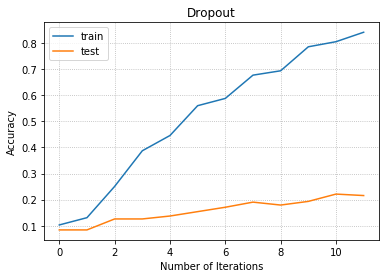

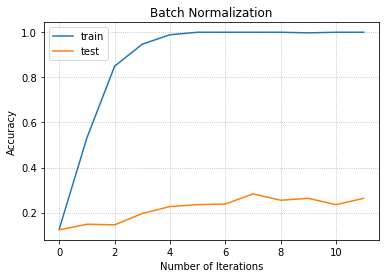

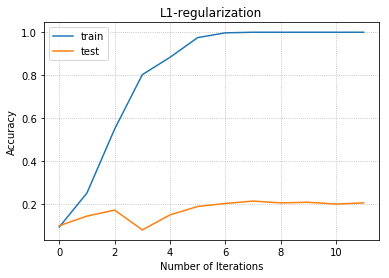

In [89]:
# compare accuracy
data = [[hist_mv2_dropout['acc'], "train"], [hist_mv2_dropout['val_acc'], "test"]]
plotAccuracy(data, "Accuracy", "Dropout")

data = [[hist_mv2_batchnorm['acc'], "train"], [hist_mv2_batchnorm['val_acc'], "test"]]
plotAccuracy(data, "Accuracy", "Batch Normalization")

data = [[hist_mv2_l1reg['acc'], "train"], [hist_mv2_l1reg['val_acc'], "test"]]
plotAccuracy(data, "Accuracy", "L1-regularization")

All regularizer methods achieve similar test accuracy, where the batch normalization achieves the best test accuracy, followed by dropout and l1-regularization. However the test accuracy for batch normalization as well as l1-regularization seems a bit more stagnant towards the end. In contrast using dropout as a regularizer has made it so that the training accuracy does not improve as quickly, and test accuracy seems to improve more consitently.

# Optimizer

Pick model using dropout (best performing model from above) and evaluate three diﬀerent optimizers: SGD, Adam, RMSprop.

#### SGD

SGD optimizer is already evaluated above with dropout. Take the opportunity to continue training.

In [90]:
epochs = 5

mv2_transfer_dropout_sgd = mv2_transfer_dropout.fit(Xtrain, ytrain, 
        batch_size=32,
        epochs=epochs,
        validation_data=(Xtest, ytest),
        verbose=1,
        shuffle=True)

score = mv2_transfer_dropout.evaluate(Xtrain, ytrain)
print(score)

score = mv2_transfer_dropout.evaluate(Xtest, ytest)
print(score)

Train on 359 samples, validate on 357 samples
Epoch 1/5
359/359 [==============================] - 146s 407ms/step - loss: 0.4653 - acc: 0.8524 - val_loss: 2.9710 - val_acc: 0.2017
Epoch 2/5
359/359 [==============================] - 144s 401ms/step - loss: 0.3373 - acc: 0.9053 - val_loss: 2.7412 - val_acc: 0.2409
Epoch 3/5
359/359 [==============================] - 141s 392ms/step - loss: 0.3456 - acc: 0.8858 - val_loss: 2.9416 - val_acc: 0.2241
Epoch 4/5
359/359 [==============================] - 139s 386ms/step - loss: 0.3504 - acc: 0.8830 - val_loss: 3.3229 - val_acc: 0.1793
Epoch 5/5
359/359 [==============================] - 42s 116ms/step
[0.09546967151686342, 0.9777158774373259]
357/357 [==============================] - 38s 107ms/step
[2.742338804971604, 0.2577030815664126]


In [91]:
mv2_transfer_dropout.save('./models/mv2_transfer_dropout5_sgd.h5')

In [92]:
hist_mv2_dropout_sgd = mv2_transfer_dropout_sgd
hist_mv2_dropout_sgd = hist_mv2_dropout_sgd.history

In [93]:
# save history
with open('./runs/hist_mv2_dropout_sgd.hist', 'w', encoding="utf-8") as fout:
    pprint(hist_mv2_dropout_sgd, fout)

#### Adam

In [94]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
#mobilenetv2_model.summary()

# last layers output
x = mobilenetv2_model.layers[33].output
# Flatten as before
x = ReLU()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(12, activation='softmax')(x)

# Transfer models
mv2_transfer_dropout_adam = Model(inputs=mobilenetv2_model.input, outputs=x)

# Adam optimizer
adam = Adam()
mv2_transfer_dropout_adam.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [95]:
epochs = 5

hist_mv2_dropout_adam = mv2_transfer_dropout_adam.fit(Xtrain, ytrain, 
        batch_size=32,
        epochs=epochs,
        validation_data=(Xtest, ytest),
        verbose=1,
        shuffle=True)

score = mv2_transfer_dropout_adam.evaluate(Xtrain, ytrain)
print(score)

score = mv2_transfer_dropout_adam.evaluate(Xtest, ytest)
print(score)

Train on 359 samples, validate on 357 samples
Epoch 1/5
359/359 [==============================] - 190s 529ms/step - loss: 11.7207 - acc: 0.0919 - val_loss: 10.3822 - val_acc: 0.1232
Epoch 2/5
359/359 [==============================] - 143s 397ms/step - loss: 10.2507 - acc: 0.1671 - val_loss: 7.1589 - val_acc: 0.1877
Epoch 3/5
359/359 [==============================] - 144s 402ms/step - loss: 5.9438 - acc: 0.3064 - val_loss: 2.9354 - val_acc: 0.1681
Epoch 4/5
359/359 [==============================] - 143s 397ms/step - loss: 2.0246 - acc: 0.3343 - val_loss: 2.3974 - val_acc: 0.1877
Epoch 5/5
359/359 [==============================] - 38s 106ms/step
[1.4895570211755864, 0.5292479109465246]
357/357 [==============================] - 37s 104ms/step
[2.326233803057203, 0.238095238178718]


In [96]:
mv2_transfer_dropout_adam.save('./models/mv2_transfer_dropout5_adam.h5')

In [99]:
hist_mv2_dropout_adam = hist_mv2_dropout_adam.history

In [100]:
# save history
with open('./runs/hist_mv2_dropout_adam.hist', 'w', encoding="utf-8") as fout:
    pprint(hist_mv2_dropout_adam, fout)

#### RMSprop

In [102]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
#mobilenetv2_model.summary()

# last layers output
x = mobilenetv2_model.layers[33].output
# Flatten as before
x = ReLU()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(12, activation='softmax')(x)

# Transfer models
mv2_transfer_dropout_rmsprop = Model(inputs=mobilenetv2_model.input, outputs=x)

# RMSprop optimizer
rmsprop = RMSprop()
mv2_transfer_dropout_rmsprop.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])

In [103]:
epochs = 5

hist_mv2_dropout_rmsprop = mv2_transfer_dropout_rmsprop.fit(Xtrain, ytrain, 
        batch_size=32,
        epochs=epochs,
        validation_data=(Xtest, ytest),
        verbose=1,
        shuffle=True)

score = mv2_transfer_dropout_rmsprop.evaluate(Xtrain, ytrain)
print(score)

score = mv2_transfer_dropout_rmsprop.evaluate(Xtest, ytest)
print(score)

Train on 359 samples, validate on 357 samples
Epoch 1/5
359/359 [==============================] - 205s 570ms/step - loss: 13.4691 - acc: 0.0864 - val_loss: 14.5333 - val_acc: 0.0840
Epoch 2/5
359/359 [==============================] - 140s 390ms/step - loss: 13.7561 - acc: 0.1003 - val_loss: 14.7260 - val_acc: 0.0840
Epoch 3/5
359/359 [==============================] - 140s 389ms/step - loss: 13.0948 - acc: 0.1448 - val_loss: 13.5129 - val_acc: 0.1204
Epoch 4/5
359/359 [==============================] - 143s 398ms/step - loss: 12.5854 - acc: 0.1588 - val_loss: 12.8358 - val_acc: 0.1401
Epoch 5/5
359/359 [==============================] - 37s 103ms/step
[13.051357250691789, 0.16155988870390942]
357/357 [==============================] - 35s 99ms/step
[14.240280771121926, 0.1092436974789916]


In [104]:
mv2_transfer_dropout_rmsprop.save('./models/mv2_transfer_dropout5_rmsprop.h5')

In [105]:
hist_mv2_dropout_rmsprop = hist_mv2_dropout_rmsprop.history

In [106]:
# save history
with open('./runs/hist_mv2_dropout_rmsprop.hist', 'w', encoding="utf-8") as fout:
    pprint(hist_mv2_dropout_rmsprop, fout)

#### Compare models

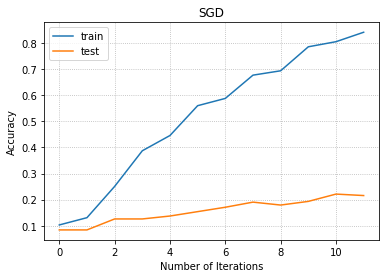

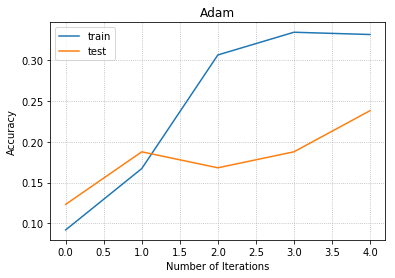

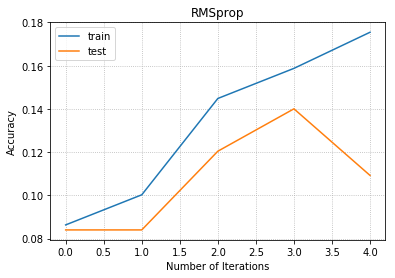

In [108]:
# compare accuracy
data = [[hist_mv2_dropout['acc'], "train"], [hist_mv2_dropout['val_acc'], "test"]]
plotAccuracy(data, "Accuracy", "SGD")

data = [[hist_mv2_dropout_adam['acc'], "train"], [hist_mv2_dropout_adam['val_acc'], "test"]]
plotAccuracy(data, "Accuracy", "Adam")

data = [[hist_mv2_dropout_rmsprop['acc'], "train"], [hist_mv2_dropout_rmsprop['val_acc'], "test"]]
plotAccuracy(data, "Accuracy", "RMSprop")

Comparing the performance, SGD, Adam and RMSprop all take roughly the same amount of time. However in theory, SGD should be faster. Comparing accuracy we believe adam performs best since it seems to be trading off training and testing accuracy more, and achieving higher test accuracy faster than SGD and RMSprop.

# Multi-task Learning

In [12]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
#mobilenetv2_model.summary()

# last layers output
x = mobilenetv2_model.layers[33].output
#x = mobilenetv2_model.layers[41].output
#x = mobilenetv2_model.layers[-1].output
#x = ReLU()(x)
x = Flatten()(x)

# Classifier task
classifier = Dense(256, activation='relu', name='clf_in')(x)
classifier = Dropout(0.5,name='clf_do')(classifier)
classifier = Dense(12, activation='softmax', name='clf_out')(classifier)

# Regression task
regression_task = Dense(256, activation='relu', name='rt_in')(x)
regression_task = Dropout(0.5, name='rt_do')(regression_task)
regression_task = Dense(4, name='rt_out')(regression_task)

# Transfer models
mv2_multitask_transfer = Model(inputs=mobilenetv2_model.input, outputs=[classifier, regression_task])

# Adam optimizer
adam = Adam()
mv2_multitask_transfer.compile(optimizer=adam, loss=['categorical_crossentropy', 'mse'], metrics=['accuracy'])

In [13]:
batch_size = 32
epochs = 10

for layer in mv2_multitask_transfer.layers:
    print(layer, layer.trainable)
    
mv2_multitask_transfer.summary()

hist_mv2_multitask = mv2_multitask_transfer.fit(
        Xtrain, [ytrain, bb_input_train],
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(Xtest, [ytest, bb_input_test]),
        verbose=1)

score = mv2_multitask_transfer.evaluate(Xtrain, [ytrain, bb_input_train])
print(score)

score = mv2_multitask_transfer.evaluate(Xtest, [ytest, bb_input_test])
print(score)

<keras.engine.input_layer.InputLayer object at 0x0000016C47383908> False
<keras.layers.convolutional.Conv2D object at 0x0000016C47383CF8> True
<keras.layers.normalization.BatchNormalization object at 0x0000016C47383C50> True
<keras.layers.advanced_activations.ReLU object at 0x0000016C47383A58> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x0000016C47344390> True
<keras.layers.normalization.BatchNormalization object at 0x0000016C4738BDD8> True
<keras.layers.advanced_activations.ReLU object at 0x0000016C46BA4E10> True
<keras.layers.convolutional.Conv2D object at 0x0000016C46C16E48> True
<keras.layers.normalization.BatchNormalization object at 0x0000016C46C8C278> True
<keras.layers.convolutional.Conv2D object at 0x0000016C46C73208> True
<keras.layers.normalization.BatchNormalization object at 0x0000016C46D12C50> True
<keras.layers.advanced_activations.ReLU object at 0x0000016C46D5E898> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x0000016C46DB9C18> True
<keras

Train on 359 samples, validate on 357 samples
Epoch 1/10
359/359 [==============================] - 409s 1s/step - loss: 18868.7409 - clf_out_loss: 3.5991 - rt_out_loss: 18865.1419 - clf_out_acc: 0.1922 - rt_out_acc: 0.5125 - val_loss: 18653.9018 - val_clf_out_loss: 2.1571 - val_rt_out_loss: 18651.7446 - val_clf_out_acc: 0.3277 - val_rt_out_acc: 0.5714
Epoch 2/10
359/359 [==============================] - 387s 1s/step - loss: 7902.7421 - clf_out_loss: 1.9261 - rt_out_loss: 7900.8159 - clf_out_acc: 0.3565 - rt_out_acc: 0.5515 - val_loss: 8206.1001 - val_clf_out_loss: 2.1318 - val_rt_out_loss: 8203.9682 - val_clf_out_acc: 0.2549 - val_rt_out_acc: 0.5714
Epoch 3/10
359/359 [==============================] - 396s 1s/step - loss: 6146.1250 - clf_out_loss: 2.0779 - rt_out_loss: 6144.0472 - clf_out_acc: 0.3565 - rt_out_acc: 0.5181 - val_loss: 10018.2434 - val_clf_out_loss: 2.5376 - val_rt_out_loss: 10015.7057 - val_clf_out_acc: 0.1793 - val_rt_out_acc: 0.5714
Epoch 4/10
359/359 [=============

# Additional Annotations

In [15]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
mobilenetv2_model.summary()

epochs = 10

# last layers output
x = mobilenetv2_model.layers[33].output
# Flatten as before
x = ReLU()(x)
x = Flatten()(x)

# Classifier task
classifier = Dense(256, activation='relu', name='clf_in')(x)
classifier = Dropout(0.5, name='clf_bn')(classifier)
classifier = Dense(12, activation='softmax', name='clf_out')(classifier)

# Regression task
regression_task = Dense(256, activation='relu', name='rt_in')(x)
regression_task = Dropout(0.5, name='rt_bn')(regression_task)
regression_task = Dense(4, name='rt_out')(regression_task)

# Attribute task
attr_task = Dense(256, activation='relu', name='at_in')(x)
attr_task = Dropout(0.5, name='at_bn')(attr_task)
attr_task = Dense(1, activation='sigmoid', name='at_out')(attr_task)

# Transfer models
mv2_multitask_transfer = Model(inputs=mobilenetv2_model.input, outputs=[classifier, regression_task, attr_task])

adam = Adam()
mv2_multitask_transfer.compile(optimizer=adam, loss=['categorical_crossentropy', 'mse', 'binary_crossentropy'], metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

In [17]:
for layer in mv2_multitask_transfer.layers:
    print(layer, layer.trainable)
    
mv2_multitask_transfer.summary()

hist_mv2_multitask = mv2_multitask_transfer.fit(
        Xtrain, [ytrain, bb_input_train, attr_train],
        batch_size=32,
        epochs=epochs,
        validation_data=(Xtest, [ytest, bb_input_test, attr_test]),
        verbose=1)

<keras.engine.input_layer.InputLayer object at 0x0000016C70099470> False
<keras.layers.convolutional.Conv2D object at 0x0000016C700999B0> True
<keras.layers.normalization.BatchNormalization object at 0x0000016C70181278> True
<keras.layers.advanced_activations.ReLU object at 0x0000016C70181358> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x0000016C5B9CFEB8> True
<keras.layers.normalization.BatchNormalization object at 0x0000016C70181518> True
<keras.layers.advanced_activations.ReLU object at 0x0000016C701C9358> True
<keras.layers.convolutional.Conv2D object at 0x0000016C7025FDA0> True
<keras.layers.normalization.BatchNormalization object at 0x0000016C715586D8> True
<keras.layers.convolutional.Conv2D object at 0x0000016C71601A90> True
<keras.layers.normalization.BatchNormalization object at 0x0000016C72A17438> True
<keras.layers.advanced_activations.ReLU object at 0x0000016C72A76CC0> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x0000016C72AA62B0> True
<keras

Train on 359 samples, validate on 357 samples
Epoch 1/10
359/359 [==============================] - 131s 365ms/step - loss: 14430.2588 - clf_out_loss: 12.1999 - rt_out_loss: 14416.3140 - at_out_loss: 1.7447 - clf_out_acc: 0.0919 - rt_out_acc: 0.4373 - at_out_acc: 0.8607 - val_loss: 7112.4691 - val_clf_out_loss: 12.0644 - val_rt_out_loss: 7098.8244 - val_at_out_loss: 1.5802 - val_clf_out_acc: 0.0840 - val_rt_out_acc: 0.5714 - val_at_out_acc: 0.9020
Epoch 2/10
359/359 [==============================] - 114s 319ms/step - loss: 7041.3292 - clf_out_loss: 12.6420 - rt_out_loss: 7027.1157 - at_out_loss: 1.5714 - clf_out_acc: 0.1337 - rt_out_acc: 0.5265 - at_out_acc: 0.9025 - val_loss: 6612.8040 - val_clf_out_loss: 11.7928 - val_rt_out_loss: 6599.4310 - val_at_out_loss: 1.5802 - val_clf_out_acc: 0.1176 - val_rt_out_acc: 0.4762 - val_at_out_acc: 0.9020
Epoch 3/10
359/359 [==============================] - 119s 330ms/step - loss: 5838.5967 - clf_out_loss: 12.2009 - rt_out_loss: 5824.8245 - at_ou